In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import seaborn as sns


np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [2]:
raw_data = pd.read_csv('data/train.csv')

C:\Users\Ethan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
raw_data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [4]:
plays = np.unique(raw_data['PlayId'])
plays_trn, plays_tst = train_test_split(plays, train_size=0.75)
data_trn = raw_data[raw_data['PlayId'].isin(plays_trn)]
data_tst = raw_data[raw_data['PlayId'].isin(plays_tst)]

In [38]:
offense_players = []
offense_yards = []
defense_players = []
defense_yards = []
for _,play in data_trn.groupby(['PlayId']):
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    runner = play.loc[play['NflId'] == play['NflIdRusher']]
    opx = runner['X']
    opy = runner['Y']
    oox = np.sin(np.deg2rad(runner['Orientation']))
    ooy = np.cos(np.deg2rad(runner['Orientation']))
    ovx = runner['S'] * np.sin(np.deg2rad(runner['Dir']))
    ovy = runner['S'] * np.cos(np.deg2rad(runner['Dir']))
    oax = runner['A'] * np.sin(np.deg2rad(runner['Dir']))
    oay = runner['A'] * np.cos(np.deg2rad(runner['Dir']))
    for _,player in play.iterrows():
        px = player['X']-opx if direction == 'right' else opx-player['X']
        py = player['Y']-opy
        ox = np.sin(np.deg2rad(player['Orientation']))-oox
        oy = np.cos(np.deg2rad(player['Orientation']))-ooy
        vx = player['S']*np.sin(np.deg2rad(player['Dir']))-ovx
        vy = player['S']*np.cos(np.deg2rad(player['Dir']))-ovy
        ax = player['A']*np.sin(np.deg2rad(player['Dir']))-oax
        ay = player['A']*np.cos(np.deg2rad(player['Dir']))-oay
        pos = [i.values[0] for i in [px,py,ox,oy,vx,vy,ax,ay]]
        if ~np.isnan(pos).any():
            if player['Team'] == offense_team:
                offense_players.append(pos)
                offense_yards.append(yards)
            else:
                defense_players.append(pos)
                defense_yards.append(yards)

In [48]:
offense_nn = NearestNeighbors(metric='euclidean')
offense_nn.fit(np.stack(offense_players))
defense_nn = NearestNeighbors(metric='euclidean')
defense_nn.fit(np.stack(defense_players))
#K = [1,10,20,30,40,50,60,70,80,90,100]
R = [1,2,3,4,5,6,7,8,9,10,15,20,30,50]
mse = []
for r in R:
    se = []
    for _,play in data_tst.groupby(['PlayId']):
        offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
        direction = play['PlayDirection'].iloc[0]
        yards = play['Yards'].iloc[0]
        runner = play.loc[play['NflId'] == play['NflIdRusher']]
        opx = runner['X']
        opy = runner['Y']
        oox = np.sin(np.deg2rad(runner['Orientation']))
        ooy = np.cos(np.deg2rad(runner['Orientation']))
        ovx = runner['S'] * np.sin(np.deg2rad(runner['Dir']))
        ovy = runner['S'] * np.cos(np.deg2rad(runner['Dir']))
        oax = runner['A'] * np.sin(np.deg2rad(runner['Dir']))
        oay = runner['A'] * np.cos(np.deg2rad(runner['Dir']))
        predictions = []
        weights = []
        for _,player in play.iterrows():
            px = player['X']-opx if direction == 'right' else opx-player['X']
            py = player['Y']-opy
            ox = np.sin(np.deg2rad(player['Orientation']))-oox
            oy = np.cos(np.deg2rad(player['Orientation']))-ooy
            vx = player['S']*np.sin(np.deg2rad(player['Dir']))-ovx
            vy = player['S']*np.cos(np.deg2rad(player['Dir']))-ovy
            ax = player['A']*np.sin(np.deg2rad(player['Dir']))-oax
            ay = player['A']*np.cos(np.deg2rad(player['Dir']))-oay
            pos = np.array([i.values[0] for i in [px,py,ox,oy,vx,vy,ax,ay]],ndmin=2)
        if player['Team'] == offense_team:
            dis,ind = offense_nn.radius_neighbors(pos,radius=r)
            ind = [int(i) for i in ind[0]]
            if len(ind) > 0:
                predictions.append(np.mean(offense_yards[ind[0]]))
                weights.append(1/(1+np.mean(dis)))
        else:
            dis,ind = defense_nn.radius_neighbors(pos,radius=r)
            ind = [int(i) for i in ind[0]]
            if len(ind) > 0:
                predictions.append(np.mean(defense_yards[ind[0]]))
                weights.append(1/(1+np.mean(dis)))
        if len(predictions) > 0:
            prediction = np.mean(predictions)
            se.append((prediction-yards)*(prediction-yards))
    mse.append(np.mean(se))

<function matplotlib.pyplot.show(*args, **kw)>

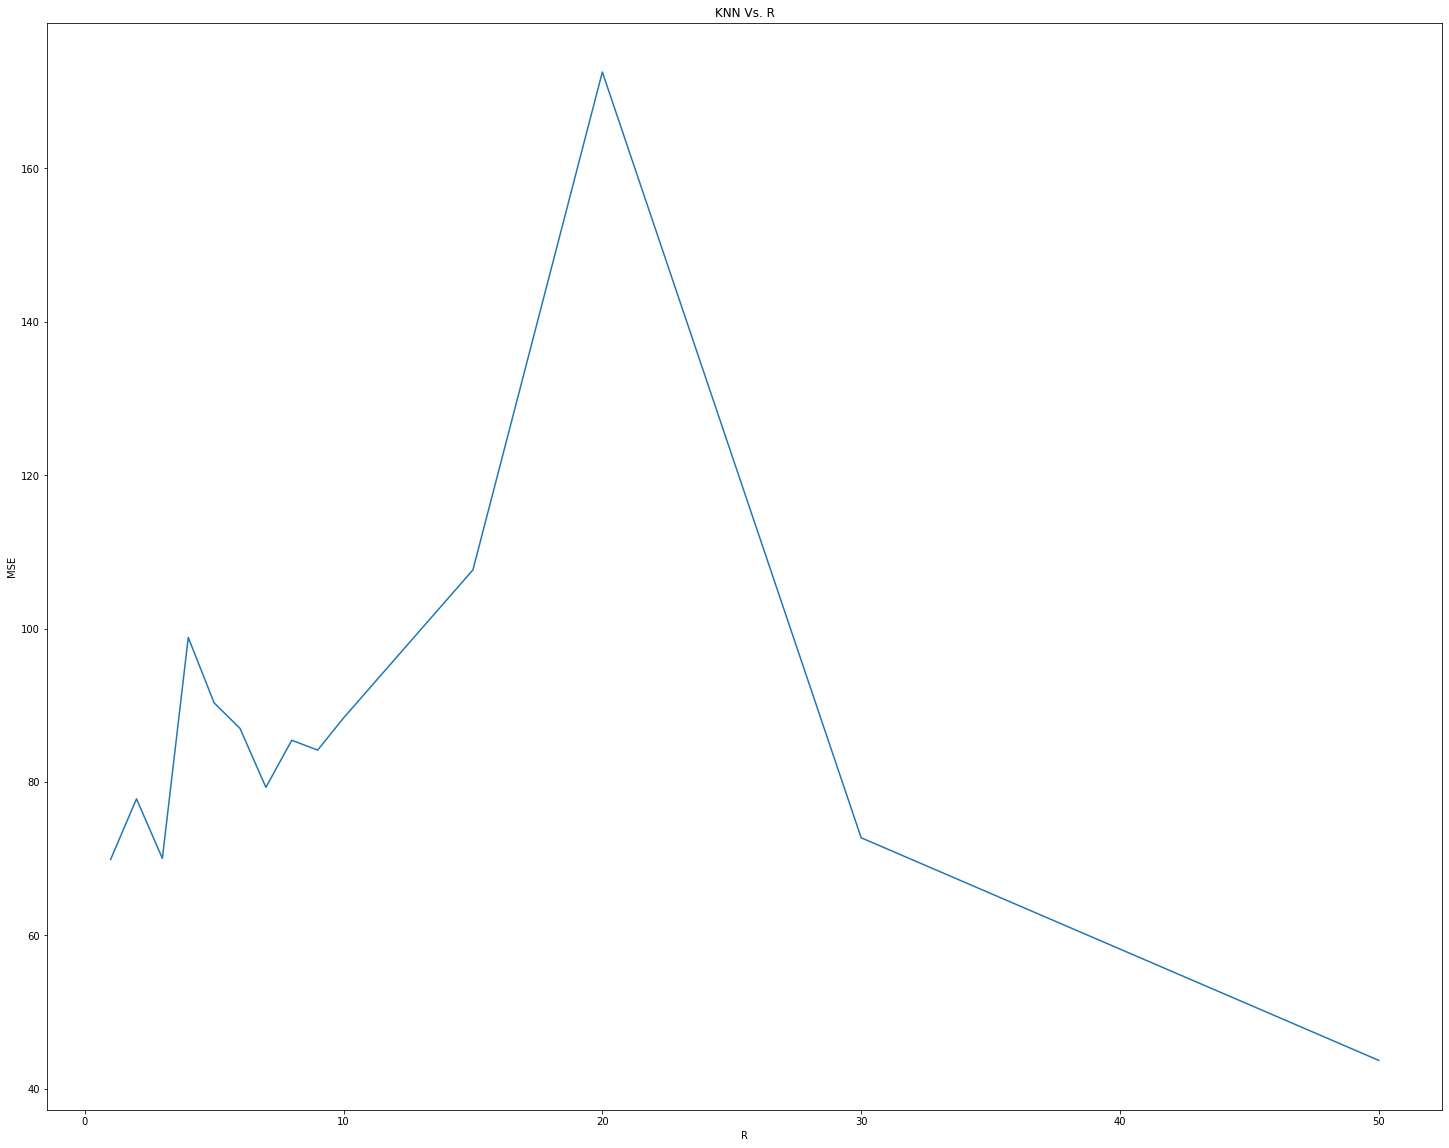

In [49]:
plt.figure(figsize=(25,20))
plt.plot(R,mse)
plt.title('KNN Vs. R')
plt.xlabel('R')
plt.ylabel('MSE')
plt.show